# Train a Simple TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training a 2.5 kB model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers.

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.

The model created in this notebook is used in the [hello_world](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world) example for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [2]:
# "!mkdir" creates a folder or directory that appears on the folders tab in google colab
!mkdir  SMART_TOOLS_ROOT_DIR
!mkdir  SMART_TOOLS_ROOT_DIR/scratch/
!mkdir  SMART_TOOLS_ROOT_DIR/scratch/base_dir
!mkdir  UTILS_DIR
!mkdir  SMART_TOOLS_ROOT_DIR/scratch/base_dir/tf_model

# The folder path strings are matched with their corresponding variables
model_base_dir='SMART_TOOLS_ROOT_DIR/scratch/base_dir/tf_model'
base_dir='SMART_TOOLS_ROOT_DIR/scratch/base_dir'


In [3]:


# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

import csv
import sys,os
import io
from collections import OrderedDict

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving OL50_10secframe_Proccessed_Test_Xy_Matrix.csv to OL50_10secframe_Proccessed_Test_Xy_Matrix.csv
Saving OL50_10secframe_Proccessed_Train_Xy_Matrix.csv to OL50_10secframe_Proccessed_Train_Xy_Matrix.csv
Saving OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv to OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv


In [ ]:

# val_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv'])).to_numpy()
# train_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Train_Xy_Matrix.csv'])).to_numpy()
# test_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Test_Xy_Matrix.csv'])).to_numpy()


# np.random.shuffle(val_df)
# np.random.shuffle(train_df)
# np.random.shuffle(test_df)

# #get rid of first element: index and last 2 elements: subject number & trial
# val_arr = val_df[:,1:-2]
# train_arr = train_df[:,1:-2]
# test_arr = test_df[:,1:-2]

# x_validate = val_arr[:,:-1]
# x_train = train_arr[:,:-1]
# x_test = test_arr[:,:-1]

# x_validate = x_validate.reshape(len(x_validate),11, 10)
# x_train = x_train.reshape(len(x_train),11, 10)
# x_test = x_test.reshape(len(x_test),11, 10)

# y_validate = val_arr[:,-1:]
# y_train = train_arr[:,-1:]
# y_test = test_arr[:,-1:]



In [5]:
def get_xy_numpy(df, x_features_columns, y_features_columns='Activity'):
    x_df = df[x_features_columns]
    x_np = x_df.to_numpy()
    # get the output column we want to predict
    y_df = df[y_features_columns]
    y_np = y_df.to_numpy()
    # assert the x and y dataframes do NOT have any null or NaN entries
    assert(x_df.isnull().sum().sum() == 0)
    assert(y_df.isnull().sum().sum() == 0)

    return x_np, y_np, x_df, y_df

# how many samples are taken at once for training
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

epochs = 50

# NOTE: data will be re-organized to size:
# BATCH_SIZE x NUM_SENSORS x NUM_FEATURES
# view this as an image with 1 channel, NUM_SENSORS x NUM_FEATURES size

#Three separate datasets are uploaded: Train, Validate and Test
val_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Validate_Xy_Matrix.csv']))
train_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Train_Xy_Matrix.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['OL50_10secframe_Proccessed_Test_Xy_Matrix.csv']))


print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_df.describe())
print(train_df['Activity'].value_counts())
num_activities = len(set(train_df['Activity']))

# get all columns that are inputs to our model (anything thats not labels or unnamed)
x_features_columns = [colname for colname in list(train_df) if colname not in ['Unnamed: 0', 'Activity', 'Subject Number', 'Trial', 'Unnamed: 0.1']]
y_features_columns = 'Activity'

# repeat key column extraction for train and val data

train_test_val_df_dict = OrderedDict()
train_test_val_df_dict['train'] = train_df
train_test_val_df_dict['val'] = val_df
train_test_val_df_dict['test'] = test_df

tf_dataset_dict = OrderedDict()

# min, max, mean etc.
num_features = 10
num_sensors = int(len(x_features_columns)/num_features)

# SCALE THE DATA and create a Tensorflow DataSet
# analagous to a Pytorch data loader
# KEY POINT: we manually re-scale without sklearn so we know how to replicate the scaling in C on the Arduino
# we store the scaling quantiles in train_quantile_csv, saved later

for data_split, data_df in train_test_val_df_dict.items():

    data_x_np, data_y_np, data_x_df, data_y_df = get_xy_numpy(data_df, x_features_columns, y_features_columns=y_features_columns)

    quantile_list = [.001, 0.25, 0.5, 0.75, 0.999]


    # only for training data, get the above quantiles for ALL COLUMNS and save to a csv
    if data_split == 'train':
        # do not use sklearn, instead save the following quantiles of data to a dataframe and store as a csv
        train_quantile_df = data_x_df.quantile(quantile_list)
        train_quantile_df.to_csv('/content/SMART_TOOLS_ROOT_DIR/scratch/base_dir/train_normalization_quantiles.csv')

    # for all data, scale each column using the same PER-COLUMN scaling as the training data for uniformity
    normalized_data_x_df = data_x_df.copy()
    for feature_name in data_x_df.columns:

        # do not use absolute min, max due to OUTLIERS!
        min_value = train_quantile_df[feature_name][quantile_list[0]]
        max_value = train_quantile_df[feature_name][quantile_list[-1]]

        normalized_data_x_df[feature_name] = (data_x_df[feature_name] - min_value) / (max_value - min_value)

    # now, print the stats of the normalized dataframe, the max should be roughly near 1 always
    print(' ')
    print(' ')
    print('data split: ', data_split)
    print(normalized_data_x_df.describe())
    print(' ')
    print(' ')

  ## now actually transform the training data
    data_x_np_scaled = normalized_data_x_df.to_numpy()

    ## BATCH_SIZE x NUM_SENSORS x NUM_FEATURES
    ## view this as an image with 1 channel, NUM_SENSORS x NUM_FEATURES size

    reshaped_data_x_np_scaled = data_x_np_scaled.reshape([-1, num_sensors, num_features])

    ## get a tensorflow dataset
    tf_dataset = tf.data.Dataset.from_tensor_slices((reshaped_data_x_np_scaled, data_y_np))

    # load the tensorflow dataset
    tf_dataset_dict[data_split] = tf_dataset


# we now have all the datasets and dataloaders in TENSORFLOW format
train_data = tf_dataset_dict['train'].shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_data = tf_dataset_dict['val'].batch(BATCH_SIZE)
test_data = tf_dataset_dict['test'].batch(BATCH_SIZE)

# find the number of batches in the TESTING dataset
# this is useful later
test_len = 0
for batch in test_data:
    test_len += 1

(2160, 114)
(2160, 114)
(3240, 114)
        Unnamed: 0     accX_min     accX_max    accX_mean    accX_kurt  \
count  2160.000000  2160.000000  2160.000000  2160.000000  2160.000000   
mean   1079.500000    -6.501107     2.560226    -1.684601     8.411726   
std     623.682612    26.200708    15.183595     5.893925    19.169999   
min       0.000000  -724.121094   -21.350098   -38.897365    -1.914826   
25%     539.750000    -2.773071     0.000000    -0.845020    -0.024499   
50%    1079.500000    -1.551941     0.680664    -0.343017     1.693832   
75%    1619.250000    -0.833862     1.833466    -0.011254     5.967497   
max    2159.000000     0.018799   316.833496     4.873422   170.170573   

          accX_sem     accX_std     accX_var    accX_skew     accX_mad  ...  \
count  2160.000000  2160.000000  2160.000000  2160.000000  2160.000000  ...   
mean      0.035132     1.132818    16.177383     0.379758     0.822806  ...   
std       0.119699     3.860182   175.522973     1.753777   

In [ ]:
# # Number of sample datapoints
# SAMPLES = 1000*11*10

# # Generate a uniformly distributed set of random numbers in the range from
# # 0 to 2π, which covers a complete sine wave oscillation
# x_values = np.random.uniform(
#     low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# # Shuffle the values to guarantee they're not in order
# np.random.shuffle(x_values)

# # Calculate the corresponding sine values
# # y_values = np.sin(x_values).astype(np.float32)

# y_values = np.random.randint(0,4, size=(1000))

# # Add a small random number to each y value
# # y_values += 0.1 * np.random.randn(*y_values.shape)

# x_arrs = x_values.reshape(int(len(x_values)/110),11, 10,1)
# # y_arrs = y_values.reshape(int(len(y_values)/110),11, 10)

In [ ]:
# # We'll use 60% of our data for training and 20% for testing. The remaining 20%
# # will be used for validation. Calculate the indices of each section.
# TRAIN_SPLIT =  int(0.6 * 1000)
# TEST_SPLIT = int(0.2 * 1000 + TRAIN_SPLIT)

# # Use np.split to chop our data into three parts.
# # The second argument to np.split is an array of indices where the data will be
# # split. We provide two indices, so the data will be divided into three chunks.
# x_train, x_test, x_validate = np.split(x_arrs, [TRAIN_SPLIT, TEST_SPLIT])
# y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# print(x_train.shape)

# # Double check that our splits add up correctly
# assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES


(600, 11, 10, 1)


In [ ]:
# model = tf.keras.Sequential()

# # First layer takes a scalar input and feeds it through 16 "neurons". The
# # neurons decide whether to activate based on the 'relu' activation function.
# model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# # The new second and third layer will help the network learn more complex representations
# model.add(keras.layers.Dense(16, activation='relu'))

# # Final layer is a single neuron, since we want to output a single value
# model.add(keras.layers.Dense(1))

# # Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
# model.compile(optimizer='adam', loss="mse", metrics=["mae"])



num_sensors = 11
num_features = 10
num_outputs = 4


model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(56, 3, activation='relu', input_shape=(num_sensors, num_features,1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(56, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(num_outputs, activation='softmax')])

# model = tf.keras.Sequential([
#         tf.keras.layers.Conv1D(56, 3, activation='relu', input_shape=(num_sensors, num_features)),
#         tf.keras.layers.MaxPooling1D(2, 2),
#         tf.keras.layers.Conv1D(56, 3, activation='relu'),
#         tf.keras.layers.MaxPooling1D(2, 2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(784, activation='relu'),
#         tf.keras.layers.Dense(num_outputs, activation='softmax')])

model.compile(optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

In [ ]:
# Train the model
# history = model.fit(x_train, y_train, epochs=50, batch_size=64,
#                     validation_data=(x_validate, y_validate))

# now, finally start training
model.fit(train_data,
        epochs=epochs,
        validation_data=val_data)

# test loss, test accuracy
loss, acc = model.evaluate(test_data)
pred = np.argmax(model.predict(test_data), axis=1)

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/50
34/34 [==============================] - 2s 10ms/step - loss: 1.2870 - accuracy: 0.5347 - val_loss: 1.0987 - val_accuracy: 0.6667
Epoch 2/50
34/34 [==============================] - 0s 6ms/step - loss: 0.8404 - accuracy: 0.7477 - val_loss: 0.6628 - val_accuracy: 0.8472
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 0.5923 - accuracy: 0.8218 - val_loss: 0.5215 - val_accuracy: 0.8394
Epoch 4/50
34/34 [==============================] - 0s 9ms/step - loss: 0.4189 - accuracy: 0.8769 - val_loss: 0.3955 - val_accuracy: 0.8944
Epoch 5/50
34/34 [==============================] - 0s 6ms/step - loss: 0.3657 - accuracy: 0.8884 - val_loss: 0.3316 - val_accuracy: 0.9023
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 0.3141 - accuracy: 0.8921 - val_loss: 0.2575 - val_accuracy: 0.9190
Epoch 7/50
34/34 [==============================] - 0s 8ms/step - loss: 0.2519 - accuracy: 0.9236 - val_loss: 0.2426 - val_accuracy: 0.9148
Epoch 8/50
34/34 [=

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for tup in train_data.batch(1).take(50):
      arr = np.asarray(tup[0])
      #11x10 arr
      data = np.float32(arr[0][0])
      yield([data.reshape(1,11,10,1)])


# Convert the model to the TensorFlow Lite format with quantization
# def representative_dataset():
#   for i in range(500):

#     print(train_data.batch(1).take(1)[0])

#     yield([train_data[i].reshape(1, 11,10,1)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

86432

### 2. Compare Model Performance

To prove these models are accurate even after conversion and quantization, we'll compare their predictions and loss on our test dataset.

**Helper functions**

We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. *Note: These are already included in a TF model, but not in  a TFLite model.*

In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  # x_test_ = x_test_.reshape((11,10, 1))

  print(x_test_.shape)

  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])

  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [ ]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

7/7 [==============================] - 0s 2ms/step
(200, 11, 10, 1)


ValueError: ignored

ValueError: ignored

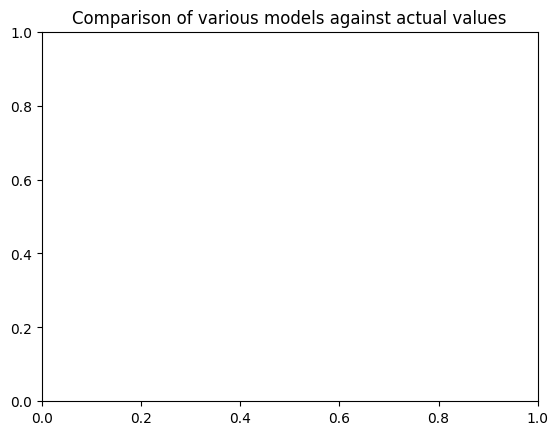

In [ ]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [954 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [991 kB]
Get:13 http://security.ubuntu.com/

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0x68, 0x38, 0x01, 0x00,
  0x78, 0x38, 0x01, 0x00, 0xcc, 0x50, 0x01, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x66, 0xc6, 0xfe, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x13, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x35, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x46, 0xc7, 0xfe, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x63, 0x